# Importing Libraries

In [170]:
import tensorflow as tf
from tensorflow.keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from lime import lime_image
from skimage.segmentation import mark_boundaries

## Loading model architecture from JSON

In [171]:
with open('C:/Users/ASHUTOSH/Desktop/EMOTION_DETECTOR/model_a.json', 'r') as json_file:
    model_json = json_file.read()

In [172]:
model = model_from_json(model_json)

## Loading model weights

In [173]:
model.load_weights('C:/Users/ASHUTOSH/Desktop/EMOTION_DETECTOR/model_weights.h5')

## Function to preprocess input image

In [174]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48, 48,))
    img = img.astype('float32')/ 255.0
#    img =np.expand_dims(img, axis=[0, -1])
    return img

In [175]:
# Function to convert grayscale image to RGB
def convert_to_rgb(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return img_rgb

## Function to generate Grad-CAM

In [176]:
def generate_gradcam(model, img_array, layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

## Loading an Image

In [177]:
#image_path = 'C:/Users/ASHUTOSH/Desktop/emotion images/shocked.jpg'
#img_array = preprocess_image(image_path)
#plt.show()

In [178]:
def get_random_image_path(root_dir):
    class_folders = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    random_class_folder = random.choice(class_folders)
    random_image = random.choice(os.listdir(random_class_folder))
    return os.path.join(random_class_folder, random_image)

# LIME Explanation Function

In [213]:
def explain_with_lime(model, image_path):
    explainer = lime_image.LimeImageExplainer()

     # Preprocess image for LIME (should match model input size)
    img = preprocess_image(image_path)
    img_rgb = convert_to_rgb(img)
#    img = cv2.cvtColor(np.squeeze(img, axis=-1), cv2.COLOR_GRAY2RGB)  # Remove single color channel dimension for LIME

     # Convert grayscale to RGB by duplicating channels
    #img_rgb = np.repeat(img, 3, axis=-1)  # Now the shape will be (48, 48, 3)
    
    # Define a prediction function for LIME
    def predict_fn(images):
#        image = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in images])
#        images = np.expand_dims(images, axis=-1)  # Add channel dimension back
        images_gray = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in images])
        images_gray = np.expand_dims(images_gray, axis=-1)
        predictions = model.predict(images)
        return predictions

    explanation = explainer.explain_instance(
        img_rgb,
        predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000  # Number of perturbations to generate for each explanation
    )

    # Get explanation for the top predicted class
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    plt.imshow(mark_boundaries(temp, mask))
    plt.axis('off')
    plt.title("LIME Explanation")
    plt.show()

In [214]:
# Set the path to your dataset directory
root_dir = 'C:/Users/ASHUTOSH/Desktop/EMOTION_DETECTOR/test/'   

In [215]:
# Get a random image path
random_image_path = get_random_image_path(root_dir)

In [216]:
# Preprocess the random image
img_array = preprocess_image(random_image_path)

## Generating Grad-CAM heatmap

In [217]:
layer_name = 'conv2d_2'
heatmap = generate_gradcam(model, np.expand_dims(img_array, axis=0), layer_name)

## Visualizing heatmap

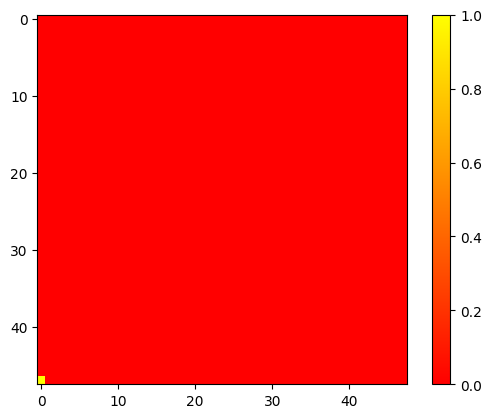

In [218]:
plt.imshow(heatmap, cmap='autumn')
plt.colorbar()
plt.show()

## Overlay heatmap on the image

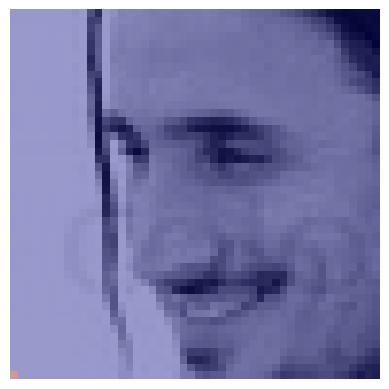

In [219]:
img = cv2.imread(random_image_path)
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

overlay_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4,0)
plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [220]:
# Apply LIME to explain the model prediction
explain_with_lime(model, random_image_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: in user code:

    File "C:\Users\ASHUTOSH\anaconda3\envs\Emotion_detection_course\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\ASHUTOSH\anaconda3\envs\Emotion_detection_course\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ASHUTOSH\anaconda3\envs\Emotion_detection_course\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\ASHUTOSH\anaconda3\envs\Emotion_detection_course\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "C:\Users\ASHUTOSH\anaconda3\envs\Emotion_detection_course\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ASHUTOSH\anaconda3\envs\Emotion_detection_course\lib\site-packages\keras\engine\input_spec.py", line 248, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model" (type Functional).
    
    Input 0 of layer "conv2d_2" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 48, 48, 3)
    
    Call arguments received by layer "model" (type Functional):
      • inputs=tf.Tensor(shape=(None, 48, 48, 3), dtype=float32)
      • training=False
      • mask=None
